# Drug Review Analysis [Part-4]

## Team 10:
- Krishna Koushik Parimi
- Ravi Tarun Prasad Nimmalapudi
- Naveen Kumar Pallanti

### Importing required libraries!

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
import nltk
from sklearn.preprocessing import LabelEncoder
from nltk.sentiment import SentimentIntensityAnalyzer
import evaluate
import tensorflow as tf
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from transformers import create_optimizer
from transformers.keras_callbacks import KerasMetricCallback
from datasets import Dataset
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset, concatenate_datasets
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Data Preprocessing

In [2]:
train_ds = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
test_ds = pd.read_csv('drugsComTest_raw.tsv', sep='\t')
conditions = train_ds['condition'].value_counts().index.tolist()[:10]
train_ds['reviewLen'] = train_ds['review'].apply(lambda x: len(x.split()))
test_ds['reviewLen'] = test_ds['review'].apply(lambda x: len(x.split()))
train_ds['wordLen'] = train_ds['review'].apply(lambda x: np.mean([len(w) for w in x.split()]))
test_ds['wordLen'] = test_ds['review'].apply(lambda x: np.mean([len(w) for w in x.split()]))

- Here we computed the length of each review in terms of word count and stored it in a new column 'reviewLen' for both train_ds and test_ds.
- Additionally, we determined each review's average word length and saved it in 'wordLen' for both datasets.
- We performed data preparation to get the data ready for further analysis.

### Depicting the most common medical conditions

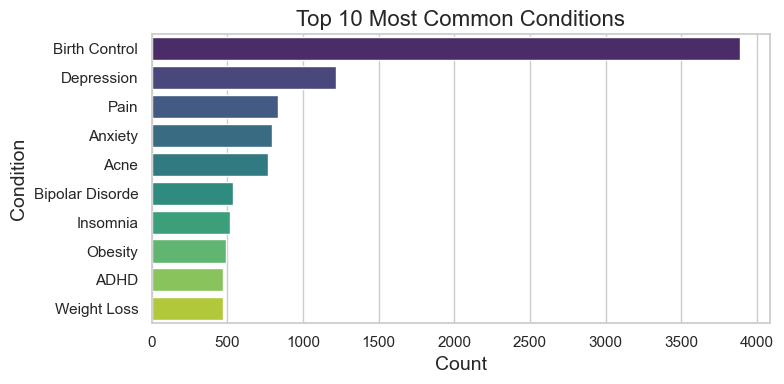

In [3]:
cluster_ds = train_ds.loc[train_ds['condition'].isin(conditions)]
cluster_ds = cluster_ds[['reviewLen', 'wordLen', 'rating', 'usefulCount','drugName', 'condition']][:10000]
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")
ax = sns.countplot(y='condition', data=cluster_ds, order = cluster_ds['condition'].value_counts().index[:20], palette='viridis')
ax.set_xlabel('Count', fontsize=14)
ax.set_ylabel('Condition', fontsize=14)
ax.set_title('Top 10 Most Common Conditions', fontsize=16)
plt.tight_layout()
plt.show()

### Normalization of Data

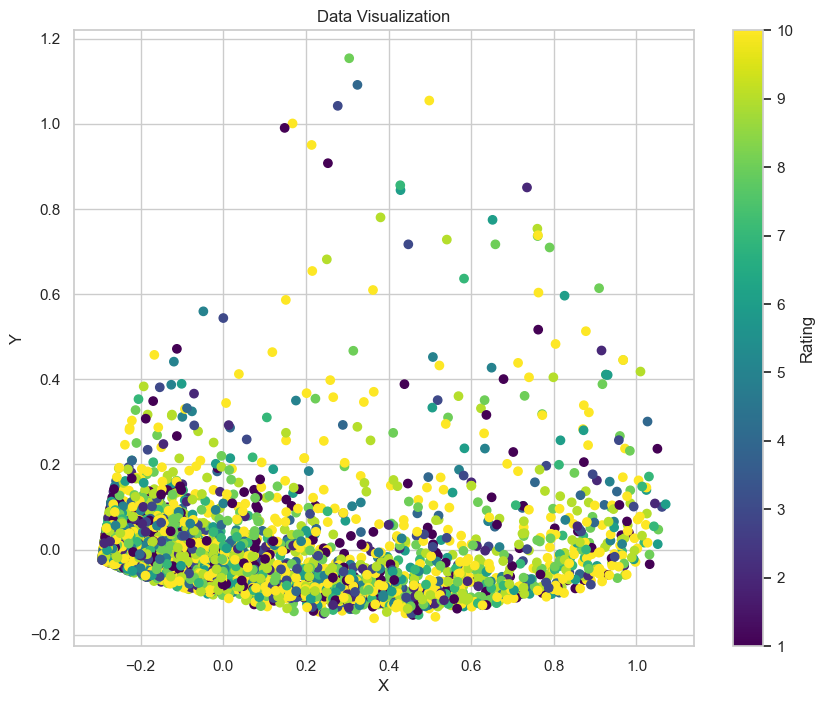

In [4]:
X = normalize(cluster_ds[['reviewLen', 'wordLen', 'rating', 'usefulCount']])
pca = PCA(n_components=2)
X = pca.fit_transform(X)
cluster_ds[['x', 'y']] = pd.DataFrame(X)
plt.figure(figsize=(10, 8))
plt.scatter(cluster_ds['x'], cluster_ds['y'], c=cluster_ds['rating'], cmap='viridis')
plt.title('Data Visualization')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Rating')
plt.grid(True)
plt.show()

- We performed dimensionality reduction using Principal Component Analysis (PCA). By reducing the dimensionality of the data to just 2-dimensions, it becomes feasible to visualize the data points in a scatter plot.
- This type of visualization can be helpful for tasks like clustering and classification as it simplifies understanding the structure of the data.

## Clustering:

### Agglomerative Clustering

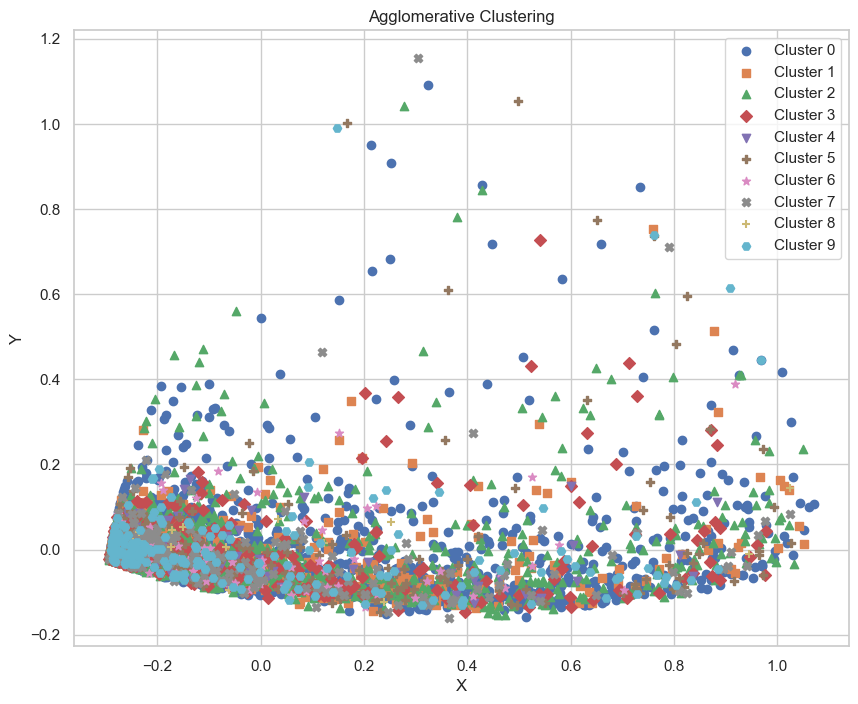

The average silhouette score is : 0.4160178320097562


In [5]:
plt.figure(figsize=(10, 8))
markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '+', 'H']
agg_cluster = AgglomerativeClustering(n_clusters=10).fit(X)
cluster_ds['agg_label'] = agg_cluster.labels_
for i in range(10):
    plt.scatter(cluster_ds.loc[agg_cluster.labels_ == i, 'x'], 
                cluster_ds.loc[agg_cluster.labels_ == i, 'y'],
                marker=markers[i], label=f'Cluster {i}')

plt.title('Agglomerative Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

agg_silhouette_avg = silhouette_score(X, agg_cluster.labels_)
print("The average silhouette score is :", agg_silhouette_avg)


### KMeans Clustering

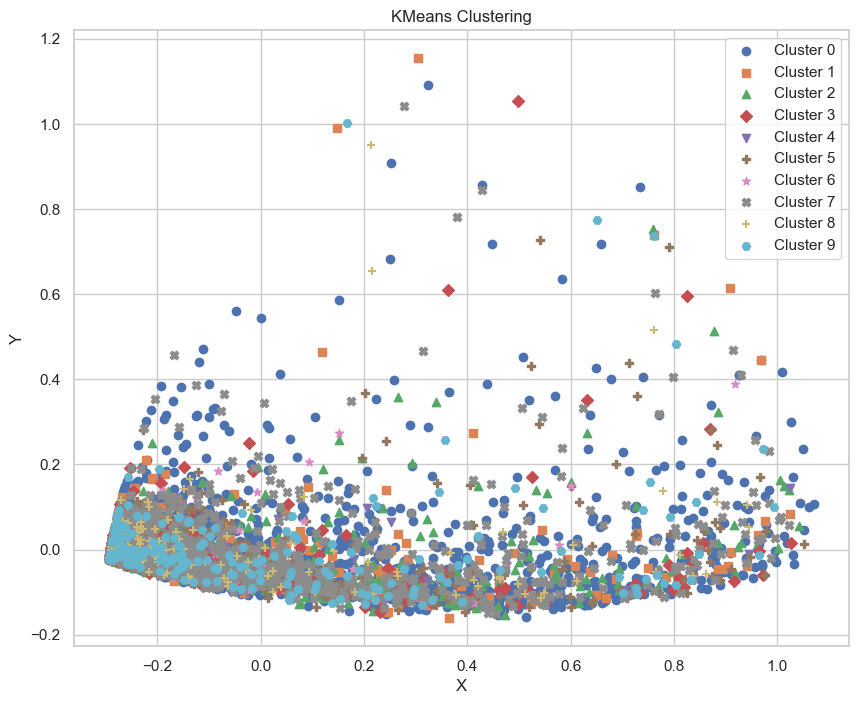

The average silhouette score is : 0.45949033717341753


In [6]:
plt.figure(figsize=(10, 8))
kmeans_cluster = KMeans(n_clusters=10, n_init='auto').fit(X)
cluster_ds['kmeans_label'] = kmeans_cluster.labels_
for i in range(10):
    plt.scatter(cluster_ds.loc[kmeans_cluster.labels_ == i, 'x'], 
                cluster_ds.loc[kmeans_cluster.labels_ == i, 'y'],
                marker=markers[i], label=f'Cluster {i}')

plt.title('KMeans Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

kmeans_silhouette_avg = silhouette_score(X, kmeans_cluster.labels_)
print("The average silhouette score is :", kmeans_silhouette_avg)

### Mini-Batch KMeans Clustering

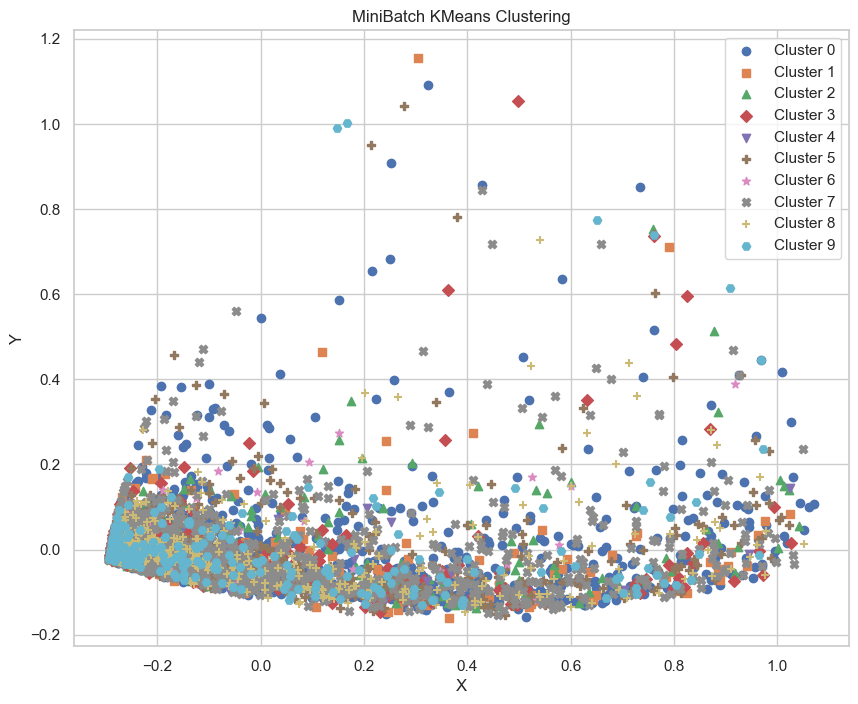

The average silhouette score is : 0.3369146167419203


In [7]:
plt.figure(figsize=(10, 8))
miniBatch_km_cluster = MiniBatchKMeans(n_clusters=10, n_init='auto').fit(X)
cluster_ds['miniBatch_km_cluster'] = miniBatch_km_cluster.labels_
for i in range(10):
    plt.scatter(cluster_ds.loc[miniBatch_km_cluster.labels_ == i, 'x'], 
                cluster_ds.loc[miniBatch_km_cluster.labels_ == i, 'y'],
                marker=markers[i], label=f'Cluster {i}')

plt.title('MiniBatch KMeans Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

miniBatch_silhouette_avg = silhouette_score(X, miniBatch_km_cluster.labels_)
print("The average silhouette score is :", miniBatch_silhouette_avg)


### Mean Shift Clustering

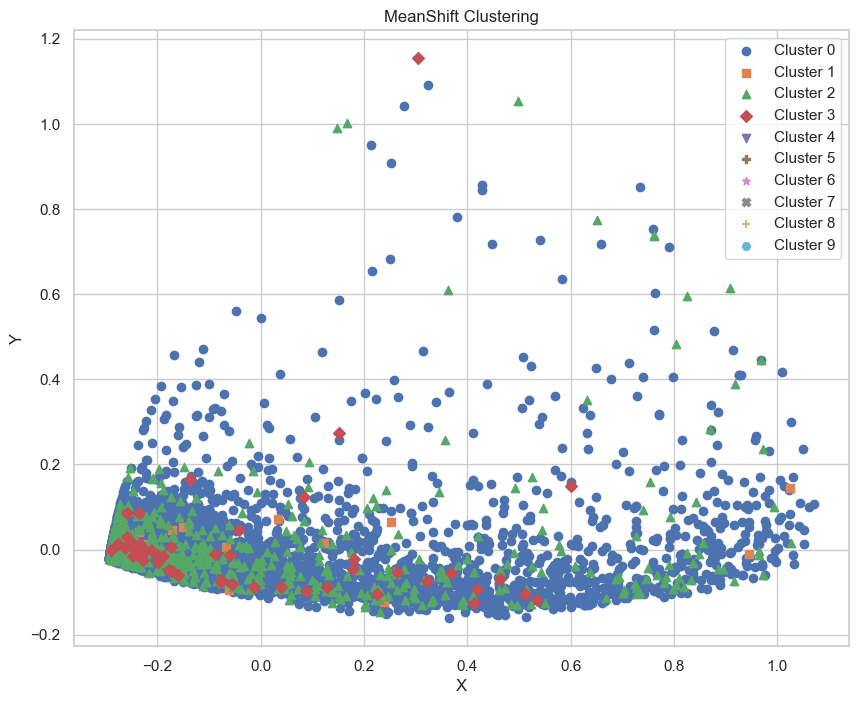

The average silhouette score is : 0.5552562045906827


In [8]:
plt.figure(figsize=(10, 8))
meanShift_cluster = MeanShift().fit(X)
cluster_ds['meanShift_cluster'] = meanShift_cluster.labels_
for i in range(10):
    plt.scatter(cluster_ds.loc[meanShift_cluster.labels_ == i, 'x'], 
                cluster_ds.loc[meanShift_cluster.labels_ == i, 'y'],
                marker=markers[i], label=f'Cluster {i}')

plt.title('MeanShift Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

meanShift_silhouette_avg = silhouette_score(X, meanShift_cluster.labels_)
print("The average silhouette score is :", meanShift_silhouette_avg)

### Comparative Analysis of Clustering Algorithms

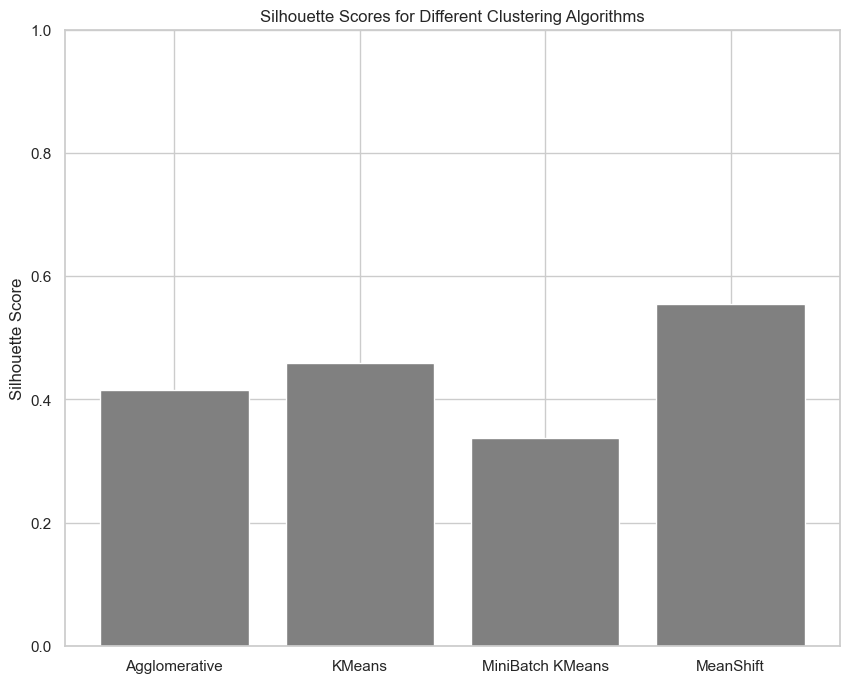

In [9]:
silhouette_scores = [agg_silhouette_avg, kmeans_silhouette_avg, miniBatch_silhouette_avg, meanShift_silhouette_avg]
labels = ['Agglomerative', 'KMeans', 'MiniBatch KMeans', 'MeanShift']

plt.figure(figsize=(10, 8))
plt.bar(labels, silhouette_scores, color='grey')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Clustering Algorithms')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

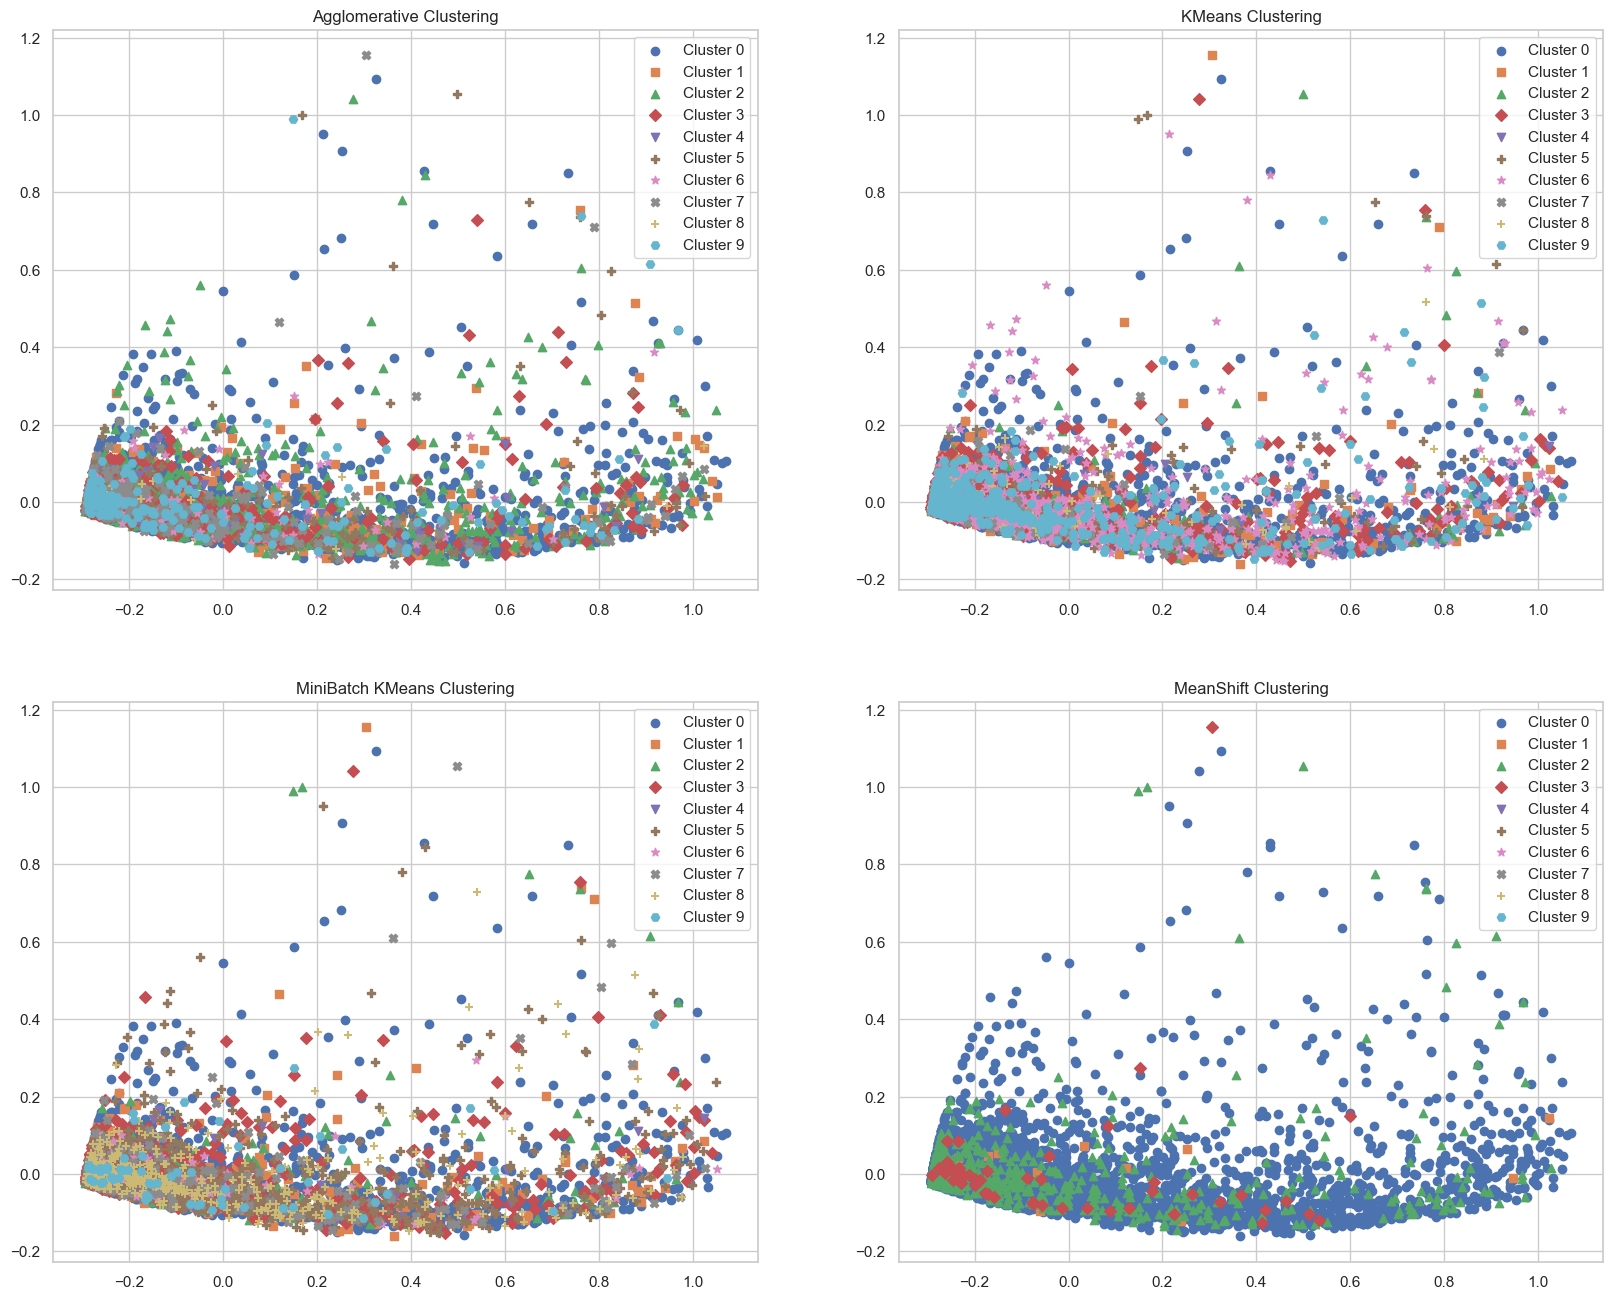

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '+', 'H']

# Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=10).fit(X)
cluster_ds['agg_label'] = agg_cluster.labels_
for i in range(10):
    axs[0, 0].scatter(cluster_ds.loc[agg_cluster.labels_ == i, 'x'], 
                      cluster_ds.loc[agg_cluster.labels_ == i, 'y'],
                      marker=markers[i], label=f'Cluster {i}')
axs[0, 0].set_title('Agglomerative Clustering')
axs[0, 0].legend()
axs[0, 0].grid(True)

# KMeans Clustering
kmeans_cluster = KMeans(n_clusters=10, n_init='auto').fit(X)
cluster_ds['kmeans_label'] = kmeans_cluster.labels_
for i in range(10):
    axs[0, 1].scatter(cluster_ds.loc[kmeans_cluster.labels_ == i, 'x'], 
                      cluster_ds.loc[kmeans_cluster.labels_ == i, 'y'],
                      marker=markers[i], label=f'Cluster {i}')
axs[0, 1].set_title('KMeans Clustering')
axs[0, 1].legend()
axs[0, 1].grid(True)

# MiniBatch KMeans Clustering
miniBatch_km_cluster = MiniBatchKMeans(n_clusters=10, n_init='auto').fit(X)
cluster_ds['miniBatch_km_cluster'] = miniBatch_km_cluster.labels_
for i in range(10):
    axs[1, 0].scatter(cluster_ds.loc[miniBatch_km_cluster.labels_ == i, 'x'], 
                      cluster_ds.loc[miniBatch_km_cluster.labels_ == i, 'y'],
                      marker=markers[i], label=f'Cluster {i}')
axs[1, 0].set_title('MiniBatch KMeans Clustering')
axs[1, 0].legend()
axs[1, 0].grid(True)

# MeanShift Clustering
meanShift_cluster = MeanShift().fit(X)
cluster_ds['meanShift_cluster'] = meanShift_cluster.labels_
for i in range(10):
    axs[1, 1].scatter(cluster_ds.loc[meanShift_cluster.labels_ == i, 'x'], 
                      cluster_ds.loc[meanShift_cluster.labels_ == i, 'y'],
                      marker=markers[i], label=f'Cluster {i}')
axs[1, 1].set_title('MeanShift Clustering')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.show()

- **MeanShift clustering appears to perform the best of the methods evaluated obtaining the highest silhouette score of 0.555 with 4 clusters.**
- **Where as KMeans, MiniBatch KMeans, and Agglomerative clustering methods have lower silhouette scores (0.45, 0.33, and 0.41, respectively).**
- **MeanShift clustering appears to be the most suitable method for clustering based on the evaluation metrics.**

## Classification:

#### Data Preparation for Classification

In [18]:
X_train = train_ds.copy()
X_test = test_ds.copy()
X_train['condition'] = LabelEncoder().fit_transform(X_train['condition'])
X_train['drugName'] = LabelEncoder().fit_transform(X_train['drugName'])
X_test['condition'] = LabelEncoder().fit_transform(X_test['condition'])
X_test['drugName'] = LabelEncoder().fit_transform(X_test['drugName'])

- We encoded categorical features 'condition' and 'drugName' using LabelEncoder for both training and testing datasets.
- The reason we used these coulmns is because 'condition' column serves as a categorical feature that provides valuable information about the specific medical conditions associated with each drug review. This can help in identifying patterns or correlations between certain medical conditions and the sentiment of the corresponding drug reviews, enabling more accurate classification or prediction of sentiments based on the condition.
- By encoding this data, machine learning algorithms are able to understand and make use of the connection between the analyzed sentiment and the medical state.

In [19]:
train_Sentiment = X_train['review'].apply(SentimentIntensityAnalyzer().polarity_scores).apply(pd.Series)
test_Sentiment = X_test['review'].apply(SentimentIntensityAnalyzer().polarity_scores).apply(pd.Series)

- SentimentIntensityAnalyzer calculates sentiment scores for each review.

In [20]:
X_train['sentiment'] = train_Sentiment['compound']
X_test['sentiment'] = test_Sentiment['compound']

In [21]:
 X_train['rating'].describe()

count    161297.000000
mean          6.994377
std           3.272329
min           1.000000
25%           5.000000
50%           8.000000
75%          10.000000
max          10.000000
Name: rating, dtype: float64

In [22]:
X_train['label'] = X_train['rating'].apply(lambda x: 1 if x > 7.0 else 0)
X_test['label'] = X_test['rating'].apply(lambda x: 1 if x > 7.0 else 0)

- We chose 7 because it's the median value for ratings.This binary labeling simplifies sentiment analysis by distinguishing between positive and negative reviews based on ratings.

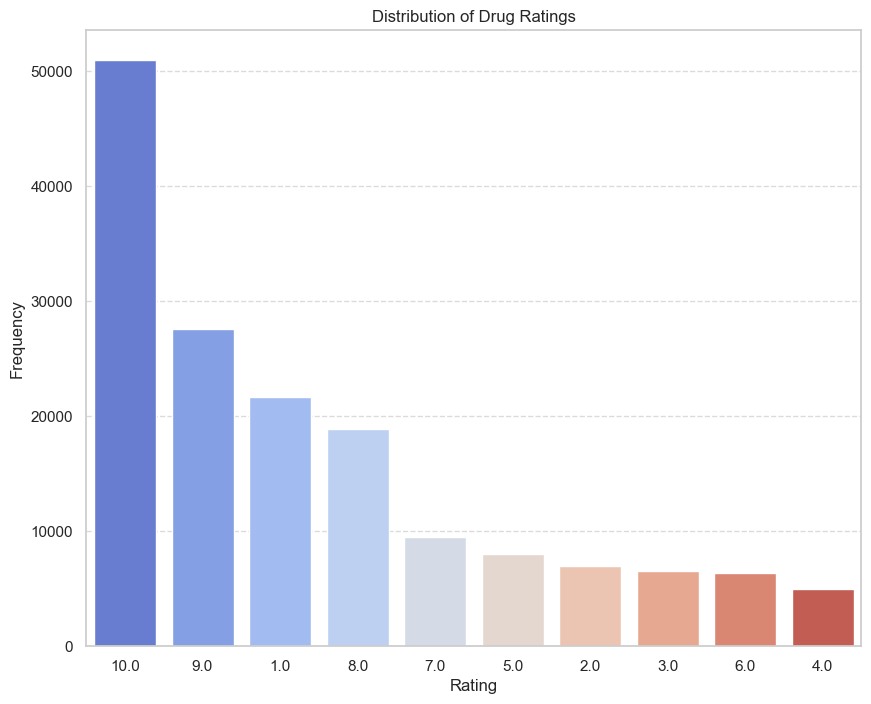

In [23]:
colors = sns.color_palette("coolwarm", len(X_train['rating'].value_counts()))

plt.figure(figsize=(10, 8))
sns.barplot(x=X_train['rating'].value_counts().index.astype(str), y=X_train['rating'].value_counts().values, palette=colors)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Drug Ratings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

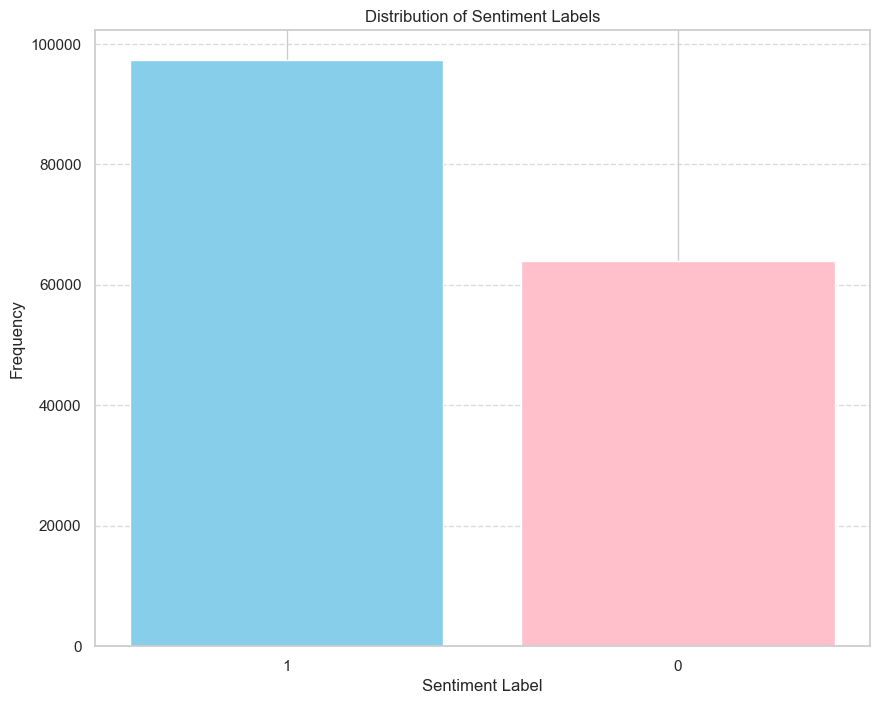

In [24]:
colors = ['skyblue', 'pink']

plt.figure(figsize=(10, 8))
plt.bar(X_train['label'].value_counts().index.astype(str), X_train['label'].value_counts().values, color=colors)
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [25]:
y_train = X_train['label']
y_test = X_test['label']
X_train.drop(columns=['Unnamed: 0', 'review', 'rating', 'date', 'label'],inplace=True)
X_test.drop(columns=['Unnamed: 0', 'review', 'rating', 'date', 'label'],inplace=True)

- Finally, unnecessary columns are dropped from the feature matrices to prepare the datasets for classification modeling.

## Classification Methods:

In [43]:
def plot_confusion_matrix(confusion_mat, cln):
        plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.gray)
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(cln)
        plt.xticks(tick_marks, ['0', '1'])
        plt.yticks(tick_marks, ['0', '1'])  
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.grid(False)
        plt.show()

- This function provides a convenient way to visualize and interpret the performance of a classification model based on its confusion matrix.

### Logistic Regression

[[11694  9723]
 [ 7182 25167]]


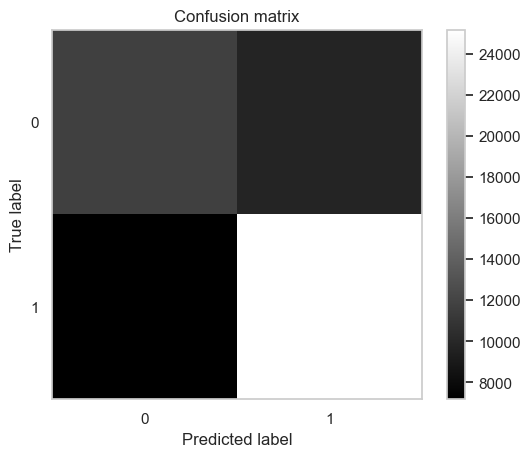

In [44]:
logesticreg_clf = LogisticRegression( random_state=42)
logesticreg_clf.fit(X_train, y_train)
y_pred = logesticreg_clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)
plot_confusion_matrix(confusion_mat, 2)

In [45]:
logReg_metrics = classification_report(y_test, y_pred)
print(logReg_metrics)

              precision    recall  f1-score   support

           0       0.62      0.55      0.58     21417
           1       0.72      0.78      0.75     32349

    accuracy                           0.69     53766
   macro avg       0.67      0.66      0.66     53766
weighted avg       0.68      0.69      0.68     53766



### Decision Tree

[[12297  9120]
 [ 7690 24659]]


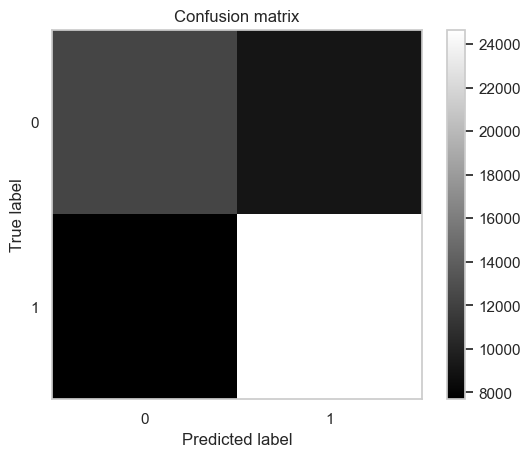

In [46]:
decisionTree_clf = DecisionTreeClassifier(max_depth = 5, random_state=42)
decisionTree_clf.fit(X_train, y_train)
y_pred = decisionTree_clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)
plot_confusion_matrix(confusion_mat, 2)

In [47]:
descisionTree_metrics = classification_report(y_test, y_pred)
print(descisionTree_metrics)

              precision    recall  f1-score   support

           0       0.62      0.57      0.59     21417
           1       0.73      0.76      0.75     32349

    accuracy                           0.69     53766
   macro avg       0.67      0.67      0.67     53766
weighted avg       0.68      0.69      0.69     53766



### KNN

[[ 8567 12850]
 [ 9807 22542]]


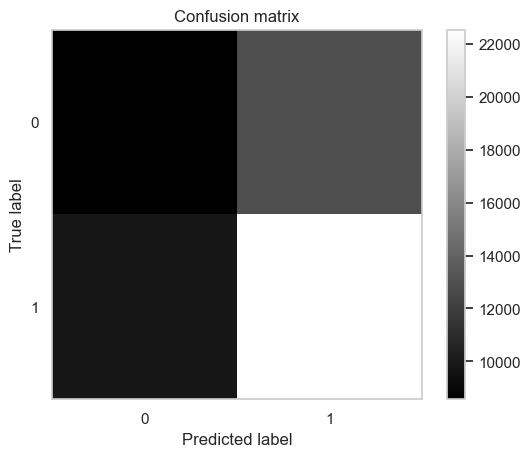

In [48]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)
plot_confusion_matrix(confusion_mat, 2)

In [49]:
knn_metrics = classification_report(y_test, y_pred)
print(knn_metrics)

              precision    recall  f1-score   support

           0       0.47      0.40      0.43     21417
           1       0.64      0.70      0.67     32349

    accuracy                           0.58     53766
   macro avg       0.55      0.55      0.55     53766
weighted avg       0.57      0.58      0.57     53766



#### Reason for choosing classifiers:

- Logistic Regression, Decision Trees, and KNN are computationally efficient and can handle relatively large datasets.
- Ultimately, a balanced approach to classification is provided by the choice of KNN, Decision Trees, and Logistic Regression, which takes into factors like robustness, computational efficiency, interpretability, and simplicity.

### Performance Evaluation of Classification Methods

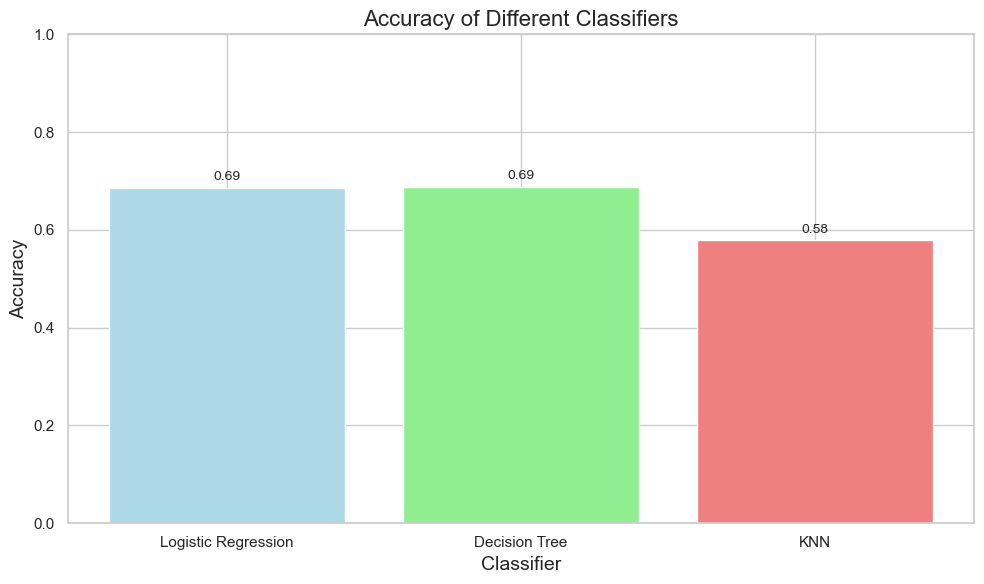

In [72]:
from sklearn.metrics import accuracy_score

classifiers = ['Logistic Regression', 'Decision Tree', 'KNN']
y_pred_logisticreg = logisticreg_clf.predict(X_test)
y_pred_decisiontree = decisiontree_clf.predict(X_test)
y_pred_knn = knn_clf.predict(X_test)
accuracy_scores = [accuracy_score(y_test, y_pred_logisticreg),
                   accuracy_score(y_test, y_pred_decisiontree),
                   accuracy_score(y_test, y_pred_knn)]

plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, accuracy_scores, color=['lightblue', 'lightgreen', 'lightcoral'])

for bar, score in zip(bars, accuracy_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 0.01, 
             f'{score:.2f}', 
             ha='center', 
             va='bottom', 
             fontsize=10)

plt.title('Accuracy of Different Classifiers', fontsize=16)
plt.xlabel('Classifier', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#### Discuss the results and show which classification method worked best and the reason.

- **Several underlying variables have been identified by the noted classifier performance, especially the relatively poor performance of KNN and the comparable performance of Decision Trees and Logistic Regression.**
- **KNN's lower accuracy of 0.58 indicates that the data lacks distinct groupings, which is not effectively captured by the KNN algorithm.**
- **On the other hand, the similar accuracies of Decision Trees and Logistic Regression, both around 0.69, indicate that the dataset's features have limited predictive power to the target variable.**
- **So we thought to introduce transformer model which can analyze and understand textual data more effectively. This model can capture patterns and relationships within the language, leading to significantly improved accuracy compared to the traditional classifiers.**

### Building the Transformer Model:

#### Building Prediction Sentiment Classifier Model

In [29]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,return_tensors="tf")
accuracy = evaluate.load("accuracy")
def preprocess_function(examples):
    return tokenizer(examples['review'], truncation=True)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [30]:
train_ds = pd.read_csv('drugsComTrain_Raw.csv')
test_ds = pd.read_csv('drugsComTest_Raw.csv')
train_ds['label'] = train_ds['rating'].apply(lambda x: 1 if x > 7.0 else 0)
test_ds['label'] = test_ds['rating'].apply(lambda x: 1 if x > 7.0 else 0)
label2id = {'POSITIVE': 1, 'NEGATIVE': 0}
id2label = {0: 'NEGATIVE', 1: 'POSITIVE'}

**Designing a workflow to train and evaluate a text classification model.**

In [ ]:
train_ds = Dataset.from_pandas(train_ds[['label', 'review']], split='train')
test_ds = Dataset.from_pandas(test_ds[['label', 'review']], split='test')
tokenized_train_ds = train_ds.map(preprocess_function, batched=True)
tokenized_test_ds = test_ds.map(preprocess_function, batched=True)
batch_size = 16
num_epochs = 3
batches_per_epoch = len(tokenized_train_ds) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0,num_train_steps=total_train_steps)
model = TFAutoModelForSequenceClassification.from_pretrained(
"distilbert-base-uncased", num_labels=2, id2label=id2label,label2id=label2id
)
tf_train_set = model.prepare_tf_dataset(
tokenized_train_ds,
shuffle=True,
batch_size=16,
collate_fn=data_collator,
)
tf_validation_set = model.prepare_tf_dataset(
tokenized_test_ds,
shuffle=False,
batch_size=16,
collate_fn=data_collator,
)
model.compile(optimizer=optimizer)
metric_callback = KerasMetricCallback(metric_fn=compute_metrics,eval_dataset=tf_validation_set)


**Training and saving the model!**

In [ ]:
 model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3,callbacks=metric_callback)

In [ ]:
model.save_pretrained('classified_Sentiment')

###  Labeling the datasets

In [55]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples['review'], truncation=True)

In [58]:
train_ds = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
test_ds = pd.read_csv('drugsComTest_raw.tsv', sep='\t')
train_ds['label'] = train_ds['rating'].apply(lambda x: 1 if x > 7.0 else 0)
test_ds['label'] = test_ds['rating'].apply(lambda x: 1 if x > 7.0 else 0)
label2id = {'POSITIVE': 1, 'NEGATIVE': 0}
id2label = {0: 'NEGATIVE', 1: 'POSITIVE'}

In [ ]:
train_ds = Dataset.from_pandas(train_ds[['label', 'review']], split='train')
test_ds = Dataset.from_pandas(test_ds[['label', 'review']], split='test')
tokenized_train_ds = train_ds.map(preprocess_function, batched=True)
tokenized_test_ds = test_ds.map(preprocess_function, batched=True)
classifier = pipeline('sentiment-analysis', model='classified_Sentiment',tokenizer=tokenizer, device=0)
results = []
for out in tqdm(classifier(KeyDataset(tokenized_test_ds, 'review'),batch_size=8, truncation="only_first"), total=len(tokenized_test_ds)):
    results.append(out)
sentiment_ds = pd.DataFrame(results)
sentiment_ds.columns = ['predicted_sentiment', 'score']
sentiment_ds = sentiment_ds.replace({'predicted_sentiment': label2id})
sentiment_dataset = Dataset.from_pandas(sentiment_ds)
concatenated_dataset = concatenate_datasets([test_ds, sentiment_dataset])
concatenated_dataset.to_csv('sentiment_test.csv')

In [57]:
from transformers import TFAutoModelForSequenceClassification
load_model = TFAutoModelForSequenceClassification.from_pretrained('classified_Sentiment')

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at classified_Sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


### Evaluating Transformer Model

[[19292  2125]
 [ 1705 30644]]


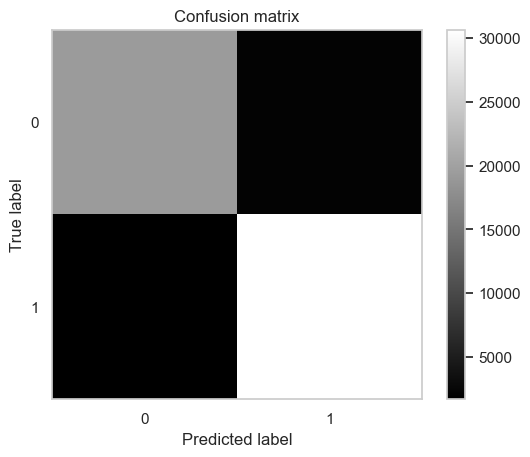

In [58]:
df = pd.read_csv('sentiment_test.csv')
y_test = df['label']
y_pred = df['predicted_sentiment']
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)
plot_confusion_matrix(confusion_mat, 2)

In [59]:
model_metrics = classification_report(y_test, y_pred)
print(model_metrics)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     21417
           1       0.94      0.95      0.94     32349

    accuracy                           0.93     53766
   macro avg       0.93      0.92      0.93     53766
weighted avg       0.93      0.93      0.93     53766



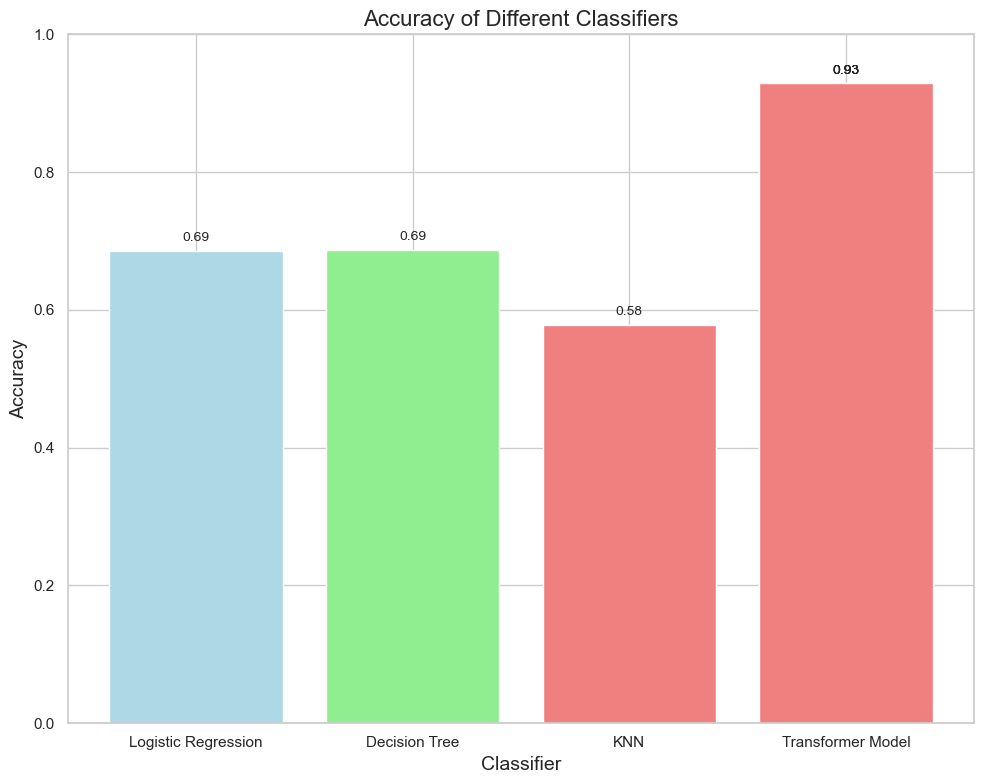

In [78]:
additional_accuracy = accuracy_score(y_test, y_pred)
accuracy_scores.append(additional_accuracy)
classifiers.append('Transformer Model')

plt.figure(figsize=(10, 8))
bars = plt.bar(classifiers, accuracy_scores, color=['lightblue', 'lightgreen', 'lightcoral', 'lightpink'])

for bar, score in zip(bars, accuracy_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 0.01, 
             f'{score:.2f}', 
             ha='center', 
             va='bottom', 
             fontsize=10)

plt.title('Accuracy of Different Classifiers', fontsize=16)
plt.xlabel('Classifier', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### Observation:
- **Utilizing sophisticated natural language processing techniques for sentiment analysis tasks can have an amazing effect, as seen by the transformer model's 0.93 accuracy, which is much greater than the accuracies of KNN, Decision Tree, and Logistic Regression classifiers.**
- **The transformer model which was created especially to handle natural language tasks performed exceptionally well at extracting rich semantic information from the drug review texts, while other classifiers, such as Logistic Regression, Decision Tree, and KNN, found it difficult to capture the complex patterns and relationships within the textual data.**
- **With an accuracy score of 0.93, this transformer model outperformed all of these classifiers.**

### Key Learnings:

- **The amount of time needed to train machine learning models is one of the project's most important lessons, especially when dealing with huge datasets and complex models.**
- **Knowing the advantages and disadvantages of traditional classifiers such as Decision Trees, Logistic Regression, and KNN, as well as the transformational power of transformer models.**
- **Determining the ideal number of clusters and assessing the quality of each cluster using measures such as silhouette score created difficulties.**